In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss

from xgboost import XGBClassifier

import shap
shap.initjs()


In [3]:
file_path = '../data/data_small_woman.csv'
df = pd.read_csv(file_path, encoding='UTF-8', low_memory=False)
df.shape

(9603, 18)

In [4]:
float_data = [
    'age',
    'BMI',
    'protein_energy_ratio',
    'fat_energy_ratio',
    'carbohydrate_energy_ratio',
    'energy',
    'pregnancy_count',
    'insulin'
]

In [5]:
categorical_data = [
    'heavy_drink',
    'smoke',
    'genetic_diabetes',
    'abdominal_obesity',
    'Hypercholesterolemia',
    'hypertriglyceridemia',
    'high_bloodpressure',
    'stroke',
    'walking_practice',
    
]

In [6]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 선택한 열에 대해 정규화 적합 및 변환
for col in float_data:
    try:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()
    except KeyError:
        pass
df.head()

age  heavy_drink  smoke  genetic_diabetes  abdominal_obesity  \
0  0.500000            0      0                 0                  0   
1  0.850000            0      0                 0                  1   
2  1.000000            0      0                 0                  0   
3  0.950000            0      0                 0                  0   
4  0.833333            0      0                 0                  1   

   Hypercholesterolemia  hypertriglyceridemia  high_bloodpressure  stroke  \
0                     0                     0                   1       0   
1                     0                     0                   3       0   
2                     0                     0                   3       0   
3                     1                     0                   3       0   
4                     1                     0                   1       0   

   myocardial_infarction       BMI  walking_practice  pregnancy_count  \
0                      0  0.257614                 0             0.20   
1                      0  0.312882                 0             0.25   
2                      0  0.148213                 1             0.00   
3                      0  0.200695                 0             0.40   
4                      0  0.250743                 1             0.20   

   protein_energy_ratio  fat_energy_ratio  carbohydrate_energy_ratio  \
0              0.309119          0.398047                   0.527290   
1              0.294999          0.442150                   0.501583   
2              0.309932          0.246287                   0.642943   
3              0.272869          0.239052                   0.669578   
4              0.307237          0.128793                   0.734375   

     energy  diabetes  
0  0.322174         0  
1  0.326692         0  
2  0.244709         0  
3  0.188469         0  
4  0.187288         0

In [7]:
y = df.diabetes
X = df.drop('diabetes', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [9]:
# SMOTE-NC를 적용할 훈련 데이터에 대한 범주형 열의 인덱스 생성
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_data]

# SMOTE-NC 적용
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=0)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# 결과 확인
print("Original training data shape:", X_train.shape, y_train.shape)
print("Resampled training data shape:", X_train_resampled.shape, y_train_resampled.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Original training data shape: (7682, 17) (7682,)
Resampled training data shape: (13146, 17) (13146,)
Test data shape: (1921, 17) (1921,)


In [10]:
X_train = X_train_resampled
y_train = y_train_resampled
# XGBModel = XGBClassifier(tree_method='gpu_hist', gpu_id=0, enable_categorical=True)
XGBModel = XGBClassifier(device='cuda', enable_categorical=True)
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

c:\Users\flinter\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


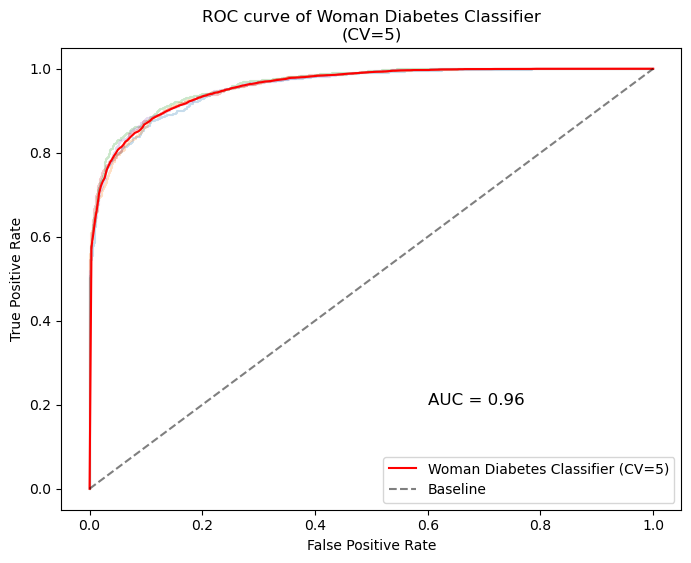

Fold 1 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 2 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 3 - AUC: 0.96, Accuracy: 0.89, F1 Score: 0.89
Fold 4 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 5 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Mean AUC: 0.96
Mean Accuracy: 0.88
Mean F1 Score: 0.88


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tprs_diabetes = []
base_fpr_diabetes = np.linspace(0, 1, 300)

# 각 fold에서의 AUC, 정확도, F1 점수를 저장할 리스트
auc_scores = []
accuracy_scores = []
f1_scores = []

# 기존 코드와 같이 ROC 곡선을 그리는 부분
plt.figure(figsize=(8, 6))
base_fpr = np.linspace(0, 1, 300)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    XGBModel.fit(X_train_fold, y_train_fold)
    
    y_val_prob_fold = XGBModel.predict_proba(X_val_fold)[:, 1]
    y_val_pred_fold = XGBModel.predict(X_val_fold)
    
    FPR_fold, TPR_fold, _ = roc_curve(y_val_fold, y_val_prob_fold)
    
    plt.plot(FPR_fold, TPR_fold, alpha=0.25)
    tpr_fold = np.interp(base_fpr_diabetes, FPR_fold, TPR_fold)
    tpr_fold[0] = 0.0
    tprs_diabetes.append(tpr_fold)
    
    # 평가 지표 계산
    auc_score_fold = roc_auc_score(y_val_fold, y_val_prob_fold)
    accuracy_score_fold = accuracy_score(y_val_fold, y_val_pred_fold)
    f1_score_fold = f1_score(y_val_fold, y_val_pred_fold)
    
    # 평가 지표 저장
    auc_scores.append(auc_score_fold)
    accuracy_scores.append(accuracy_score_fold)
    f1_scores.append(f1_score_fold)

# 최종 ROC 곡선 그리기
tprs_diabetes = np.array(tprs_diabetes)
mean_tprs_diabetes = np.mean(tprs_diabetes, axis=0)
mean_tprs_diabetes[-1] = 1.0
mean_auc = np.mean(auc_scores)

plt.plot(base_fpr, mean_tprs_diabetes, label='Woman Diabetes Classifier (CV=5)', color='red')
plt.plot([0, 1], [0, 1], label='Baseline', color='black', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Woman Diabetes Classifier\n(CV=5)')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, f'AUC = {mean_auc:.2f}', fontsize=12)
plt.show()

# 각 fold의 평가 지표 출력
for i, (auc, acc, f1) in enumerate(zip(auc_scores, accuracy_scores, f1_scores)):
    print(f'Fold {i+1} - AUC: {auc:.2f}, Accuracy: {acc:.2f}, F1 Score: {f1:.2f}')

# 최종 평균 평가 지표 출력
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.2f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.2f}')


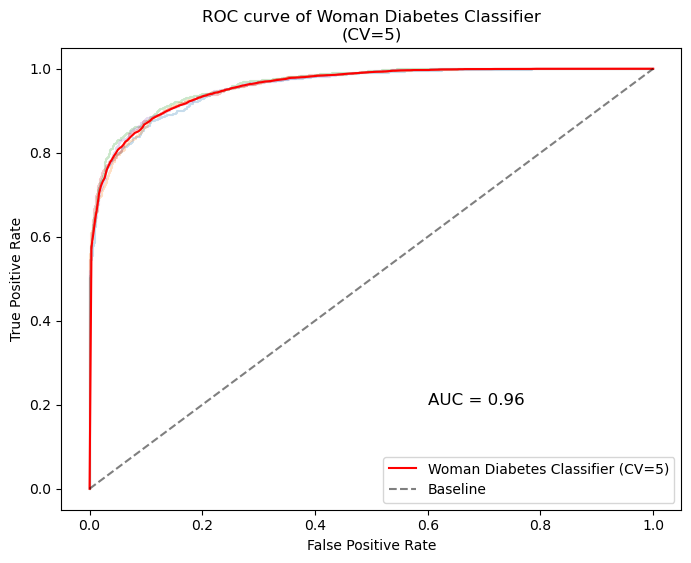

Fold 1 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 2 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 3 - AUC: 0.96, Accuracy: 0.89, F1 Score: 0.89
Fold 4 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Fold 5 - AUC: 0.96, Accuracy: 0.88, F1 Score: 0.88
Mean AUC: 0.96
Mean Accuracy: 0.88
Mean F1 Score: 0.88


In [12]:
# k-fold 검증 코드

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tprs_diabetes = []
base_fpr_diabetes = np.linspace(0, 1, 300)

# 각 fold에서의 AUC, 정확도, F1 점수를 저장할 리스트
auc_scores = []
accuracy_scores = []
f1_scores = []

# 기존 코드와 같이 ROC 곡선을 그리는 부분
plt.figure(figsize=(8, 6))
base_fpr = np.linspace(0, 1, 300)

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    XGBModel.fit(X_train_fold, y_train_fold)
    
    y_val_prob_fold = XGBModel.predict_proba(X_val_fold)[:, 1]
    y_val_pred_fold = XGBModel.predict(X_val_fold)
    
    FPR_fold, TPR_fold, _ = roc_curve(y_val_fold, y_val_prob_fold)
    
    plt.plot(FPR_fold, TPR_fold, alpha=0.25)
    tpr_fold = np.interp(base_fpr_diabetes, FPR_fold, TPR_fold)
    tpr_fold[0] = 0.0
    tprs_diabetes.append(tpr_fold)
    
    # 평가 지표 계산
    auc_score_fold = roc_auc_score(y_val_fold, y_val_prob_fold)
    accuracy_score_fold = accuracy_score(y_val_fold, y_val_pred_fold)
    f1_score_fold = f1_score(y_val_fold, y_val_pred_fold)
    
    # 평가 지표 저장
    auc_scores.append(auc_score_fold)
    accuracy_scores.append(accuracy_score_fold)
    f1_scores.append(f1_score_fold)

# 최종 ROC 곡선 그리기
tprs_diabetes = np.array(tprs_diabetes)
mean_tprs_diabetes = np.mean(tprs_diabetes, axis=0)
mean_tprs_diabetes[-1] = 1.0
mean_auc = np.mean(auc_scores)

plt.plot(base_fpr, mean_tprs_diabetes, label='Woman Diabetes Classifier (CV=5)', color='red')
plt.plot([0, 1], [0, 1], label='Baseline', color='black', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Woman Diabetes Classifier\n(CV=5)')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, f'AUC = {mean_auc:.2f}', fontsize=12)
plt.show()

# 각 fold의 평가 지표 출력
for i, (auc, acc, f1) in enumerate(zip(auc_scores, accuracy_scores, f1_scores)):
    print(f'Fold {i+1} - AUC: {auc:.2f}, Accuracy: {acc:.2f}, F1 Score: {f1:.2f}')

# 최종 평균 평가 지표 출력
print(f'Mean AUC: {np.mean(auc_scores):.2f}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.2f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.2f}')

In [13]:
# 최종 모델 학습
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
# shap 분석 시작
explainer = shap.TreeExplainer(XGBModel, X_train)
shap_values = explainer(X_test)

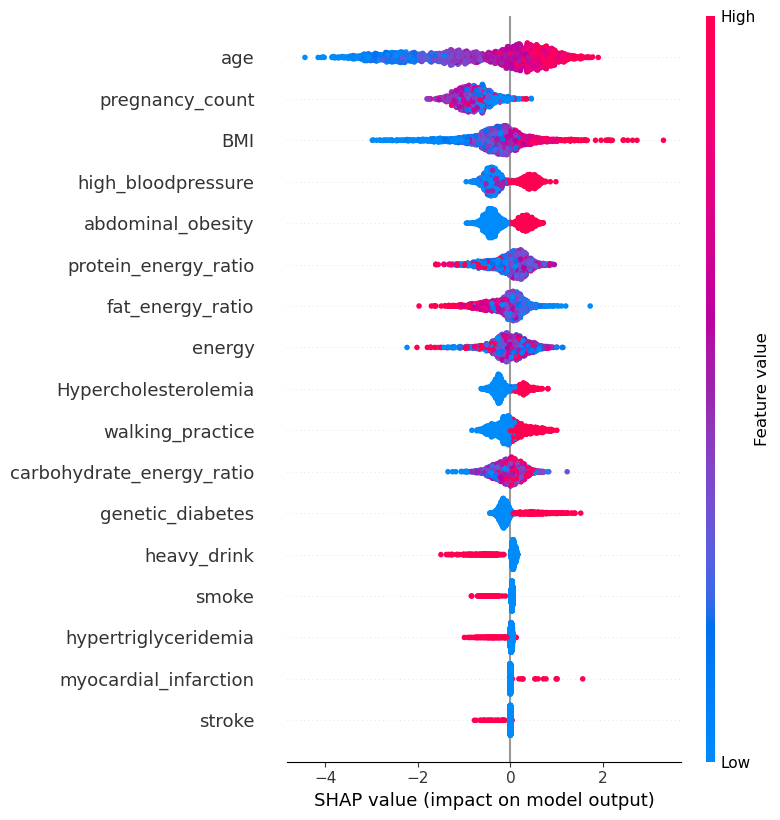

In [15]:
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns))

In [16]:
# 1. 개별 인스턴스에 대한 해석
shap_value_instance = shap_values[0]

In [17]:
# Force plot for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0,:])

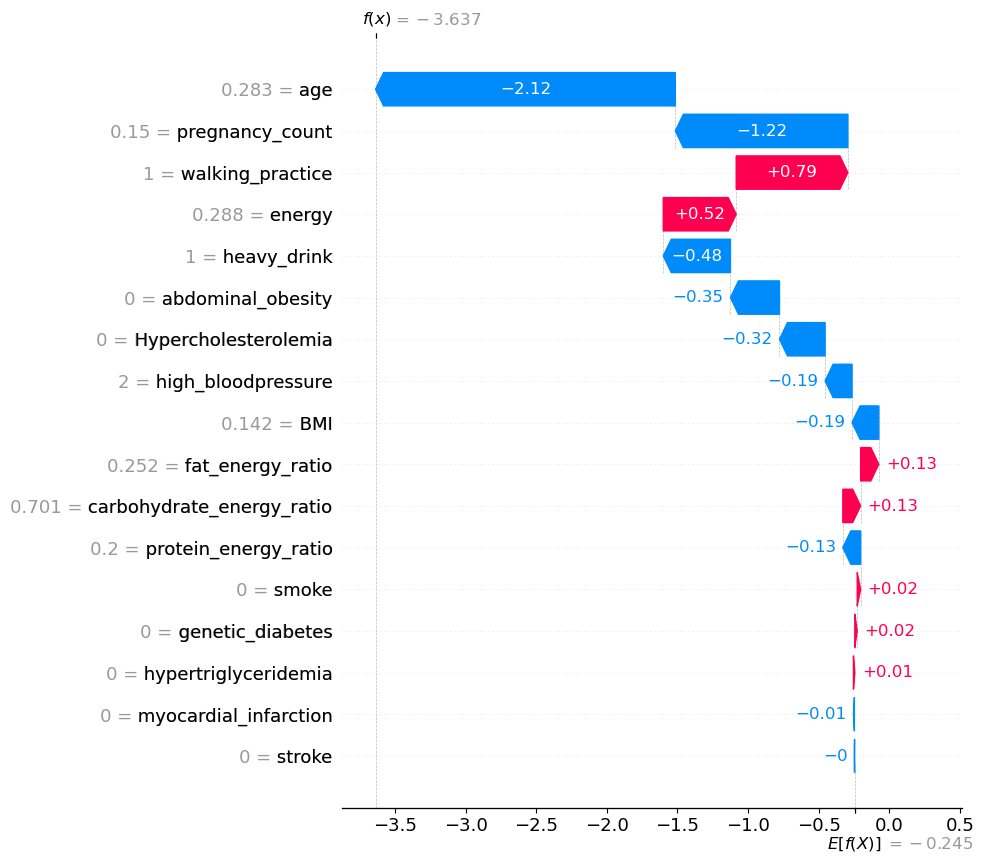

In [18]:
# Waterfall plot for the first instance
shap.waterfall_plot(shap_values[1], max_display=len(X_test.columns))

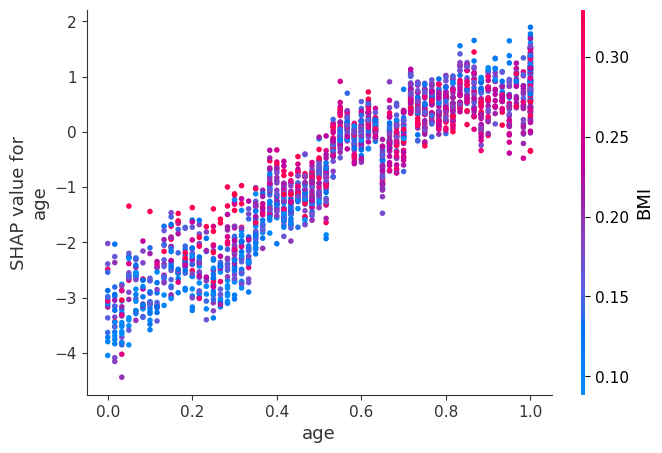

In [19]:
# 2. 특정 피처 간의 관계에 대한 해석
shap.dependence_plot("age", shap_values.values, X_test, interaction_index="auto")

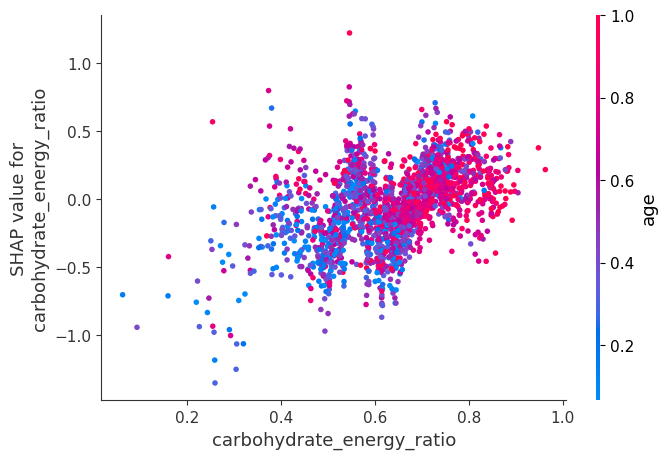

In [20]:
shap.dependence_plot("carbohydrate_energy_ratio", shap_values.values, X_test, interaction_index="auto")

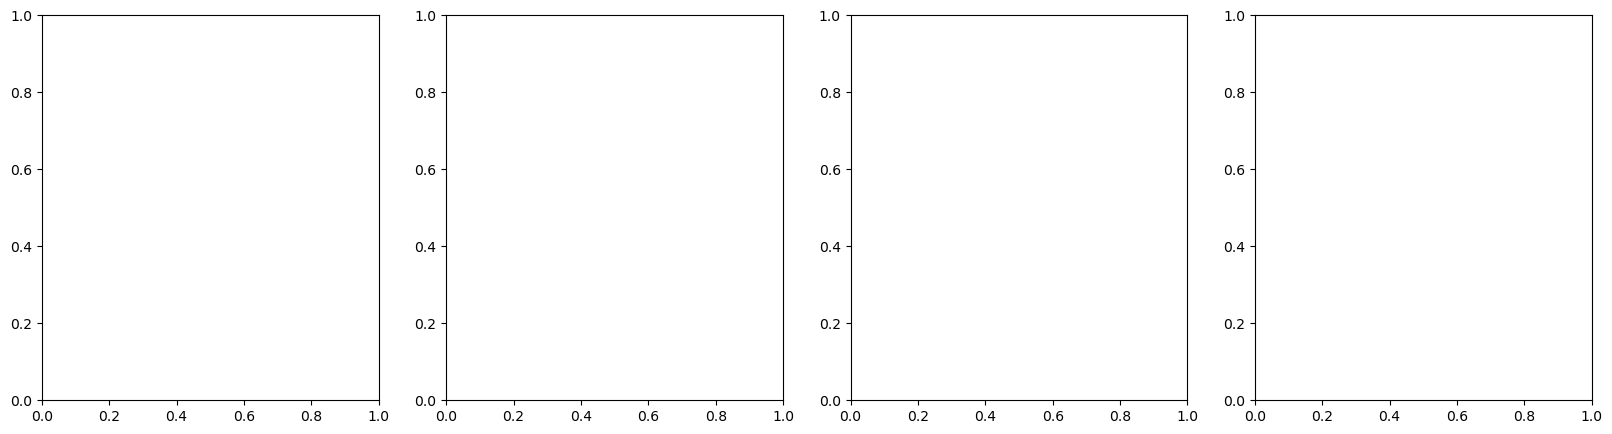

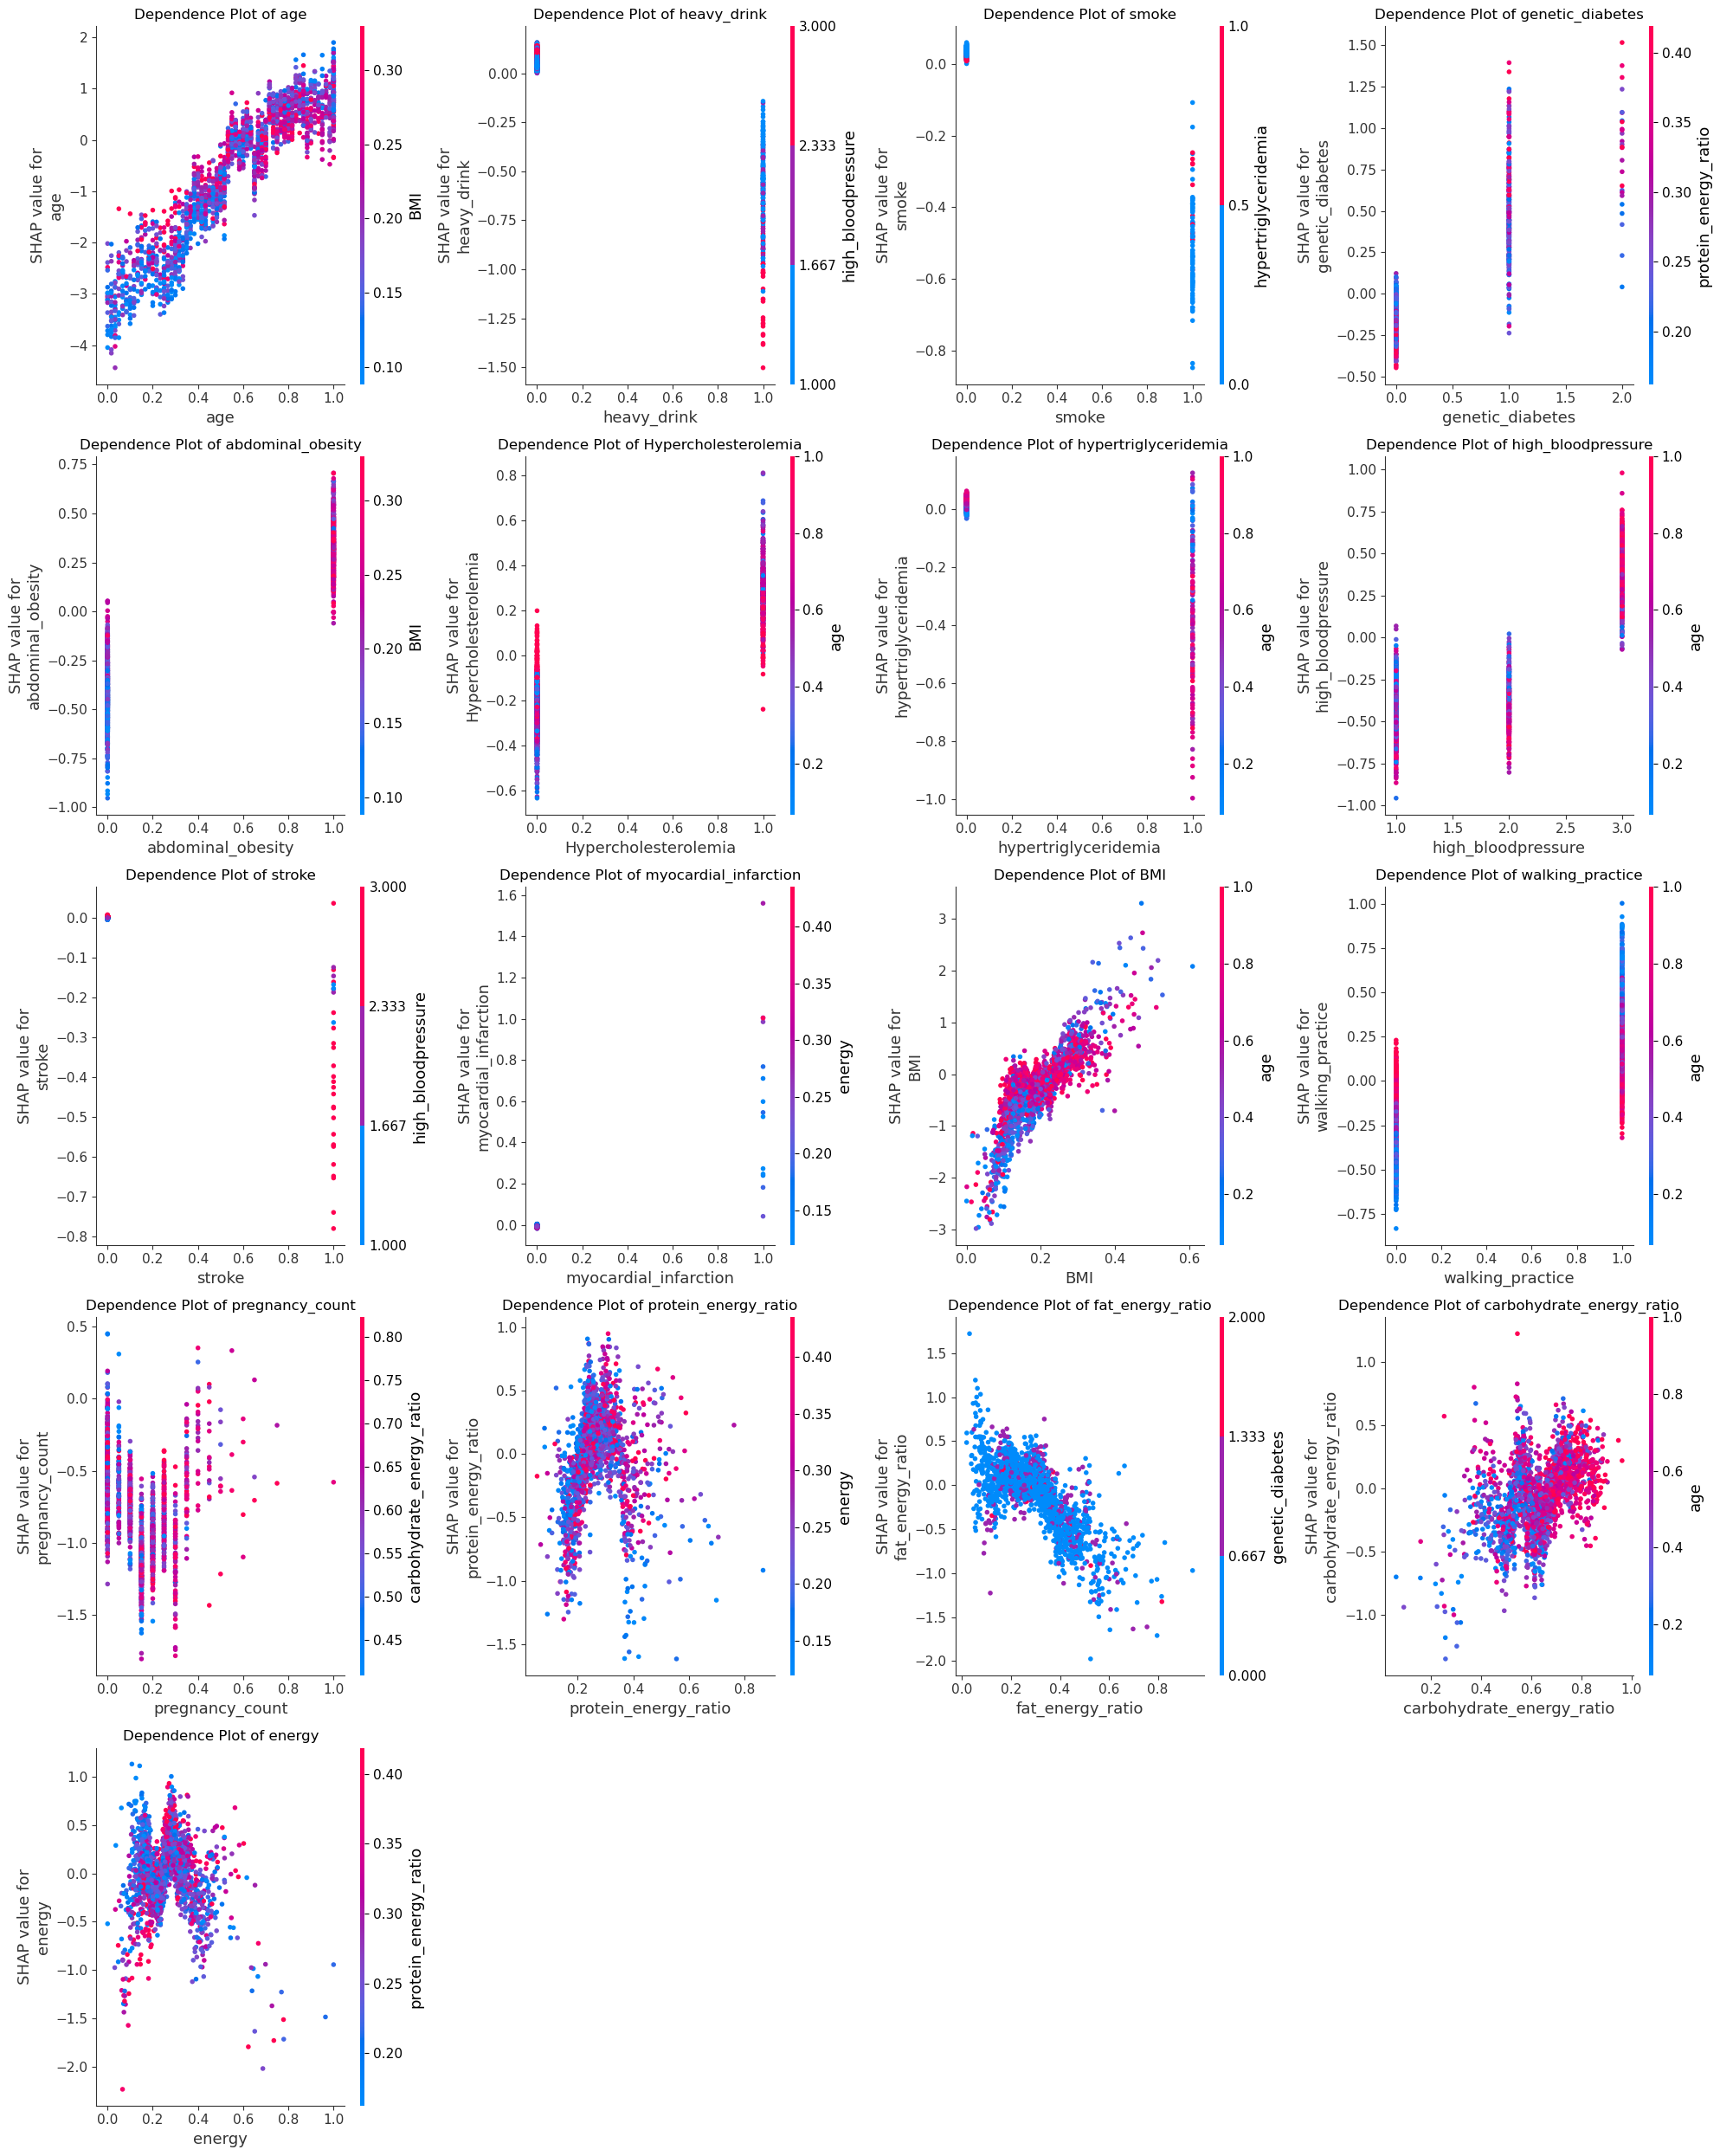

In [21]:
# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
feature_names = X_test.columns.tolist()

cols = 4  # 한 행에 4개의 그래프
rows = (len(feature_names) + cols - 1) // cols  # 필요한 행의 수 계산

# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))

# 모든 subplot을 반복하면서 각 특성의 dependence_plot을 그립니다.
for i, feature_name in enumerate(feature_names):
    ax = axs[i // cols, i % cols]
    shap.dependence_plot(feature_name, shap_values.values, X_test, interaction_index="auto", ax=ax, show=False)
    ax.set_title(f'Dependence Plot of {feature_name}')

# 사용되지 않는 subplot을 비활성화합니다.
for i in range(len(feature_names), rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


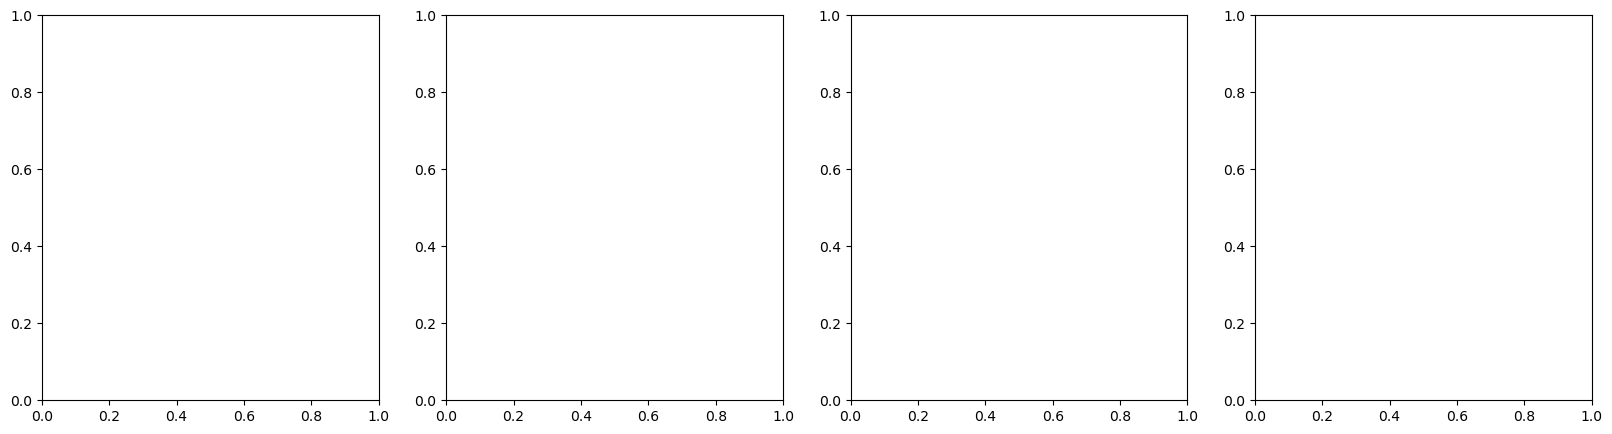

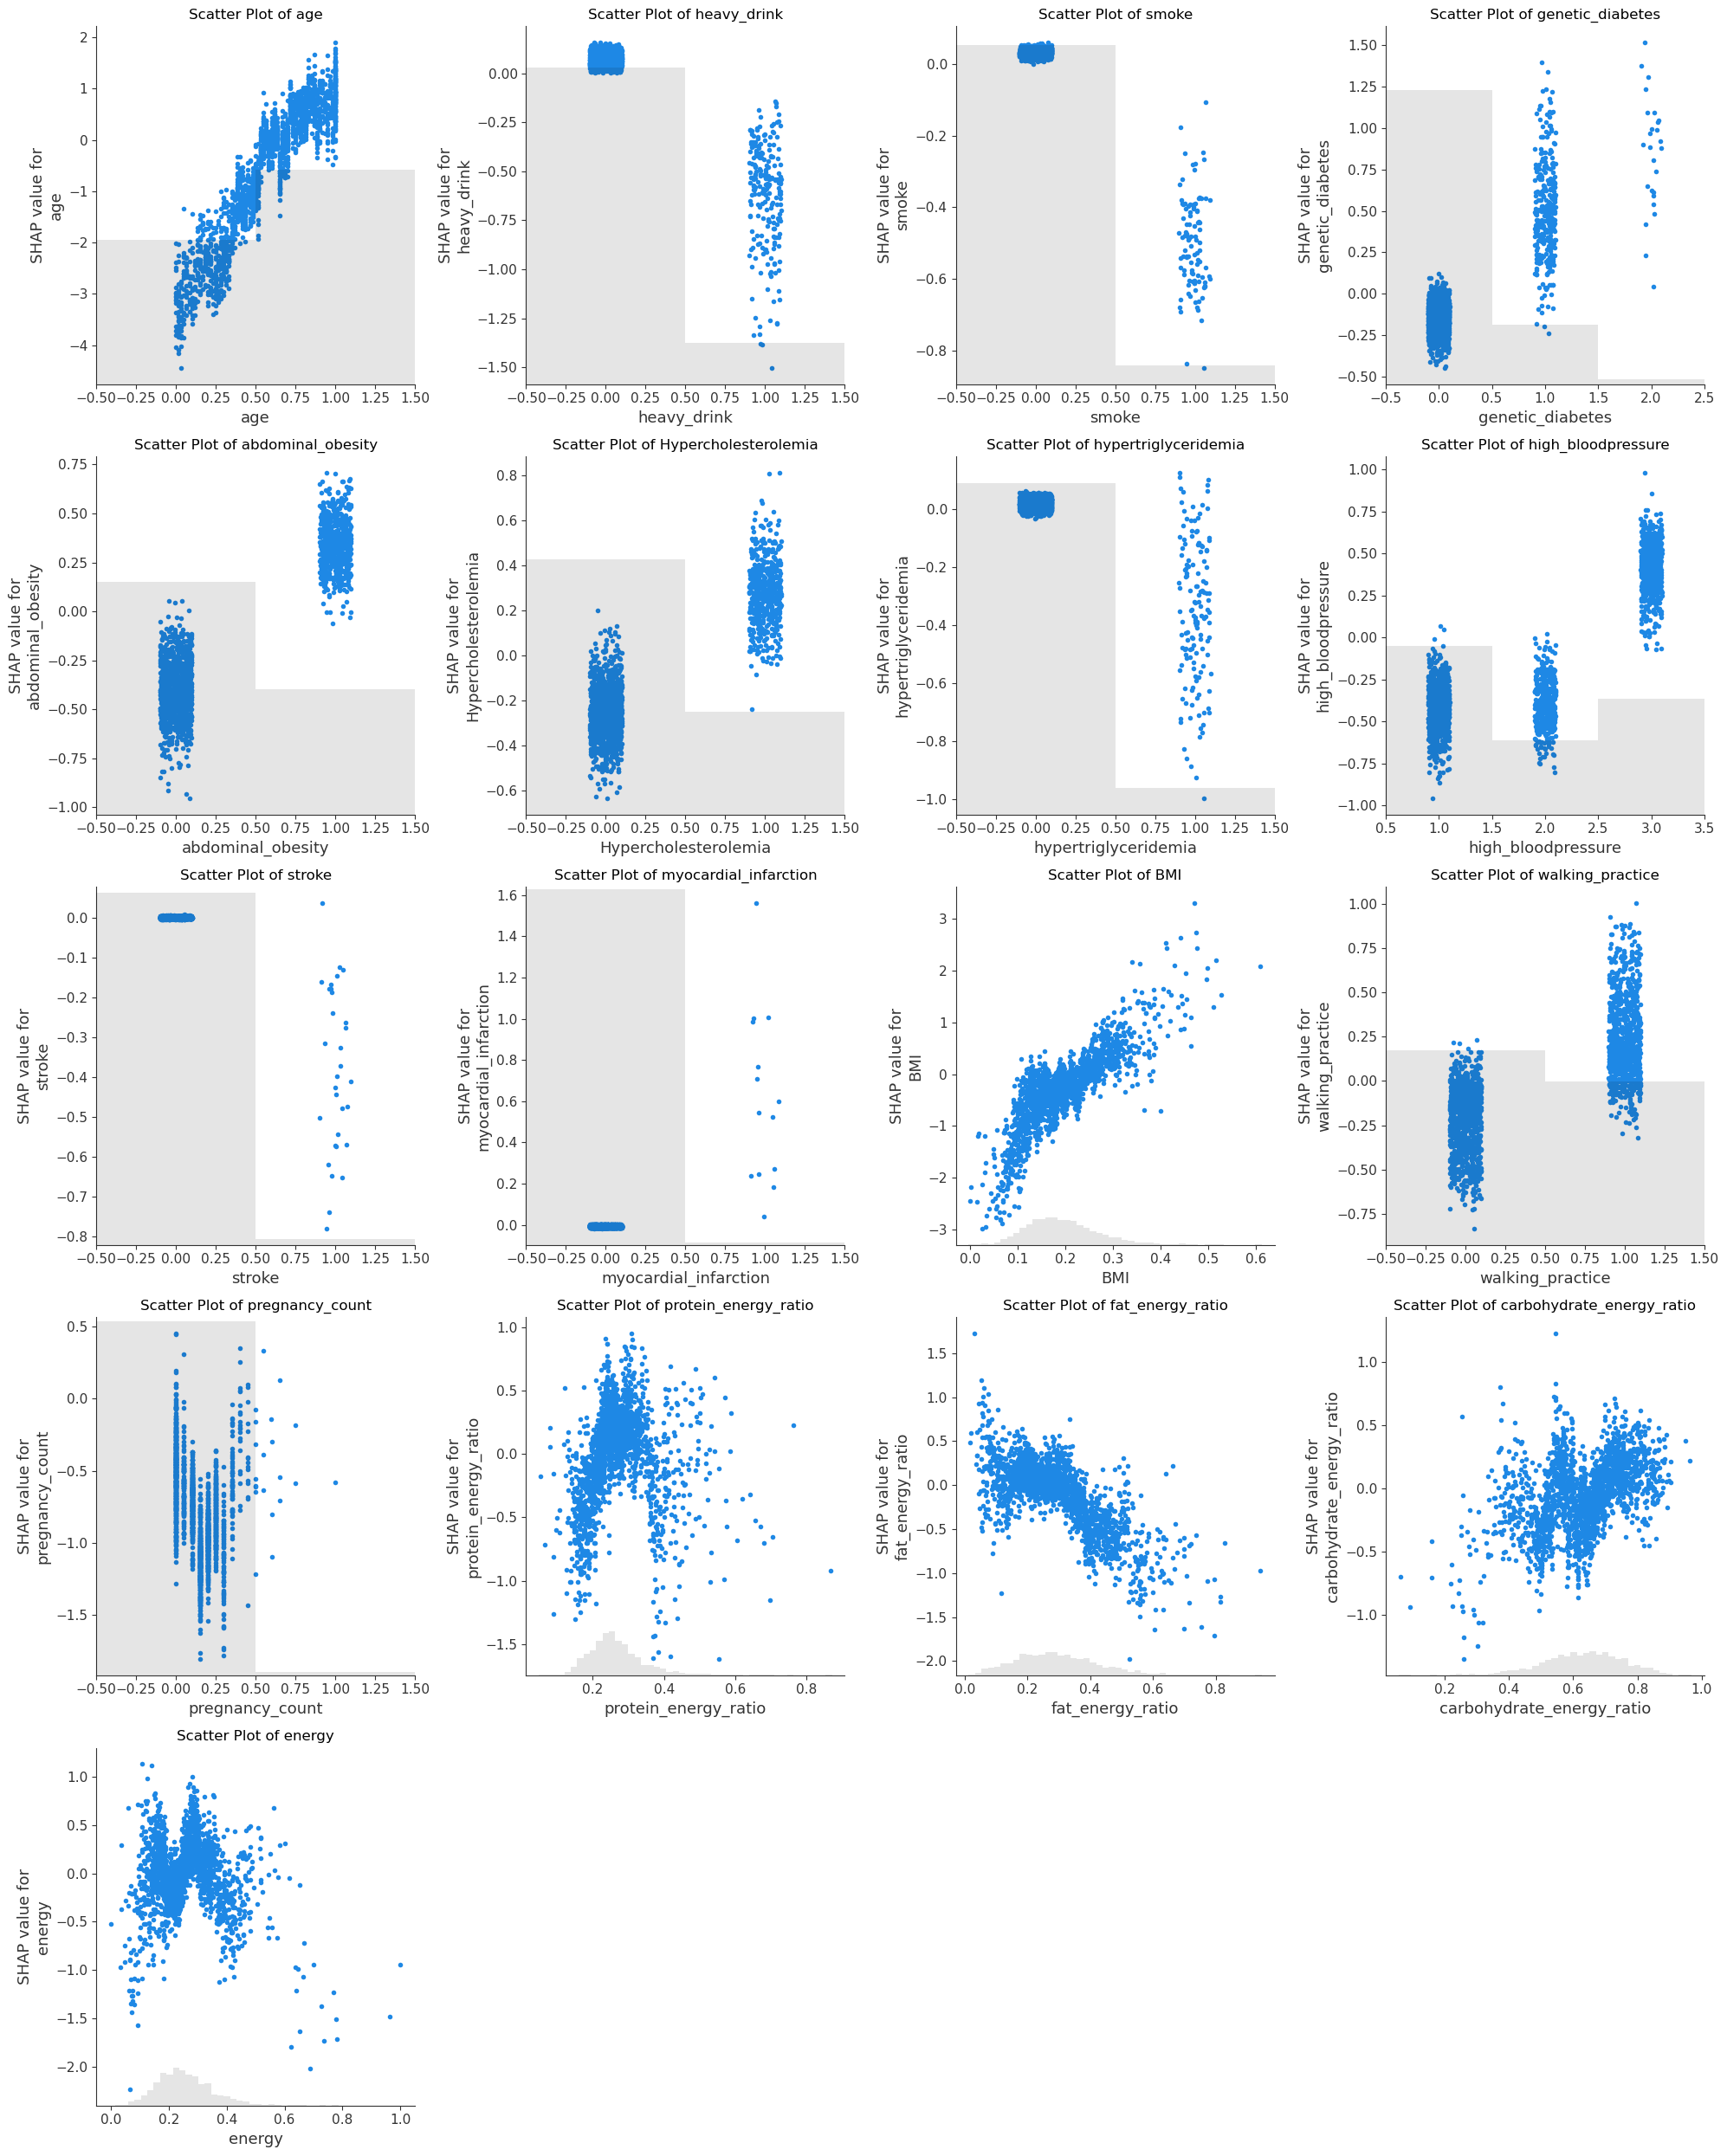

In [26]:
# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
feature_names = X_test.columns.tolist()

cols = 4  # 한 행에 4개의 그래프
rows = (len(feature_names) + cols - 1) // cols  # 필요한 행의 수 계산

# 시각화를 위한 subplot 준비
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))

# 모든 subplot을 반복하면서 각 특성의 dependence_plot을 그립니다.
for i, feature_name in enumerate(feature_names):
    ax = axs[i // cols, i % cols]
    shap.plots.scatter(shap_values[:,feature_name], ax=ax, show=False)
    ax.set_title(f'Scatter Plot of {feature_name}')

# 사용되지 않는 subplot을 비활성화합니다.
for i in range(len(feature_names), rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


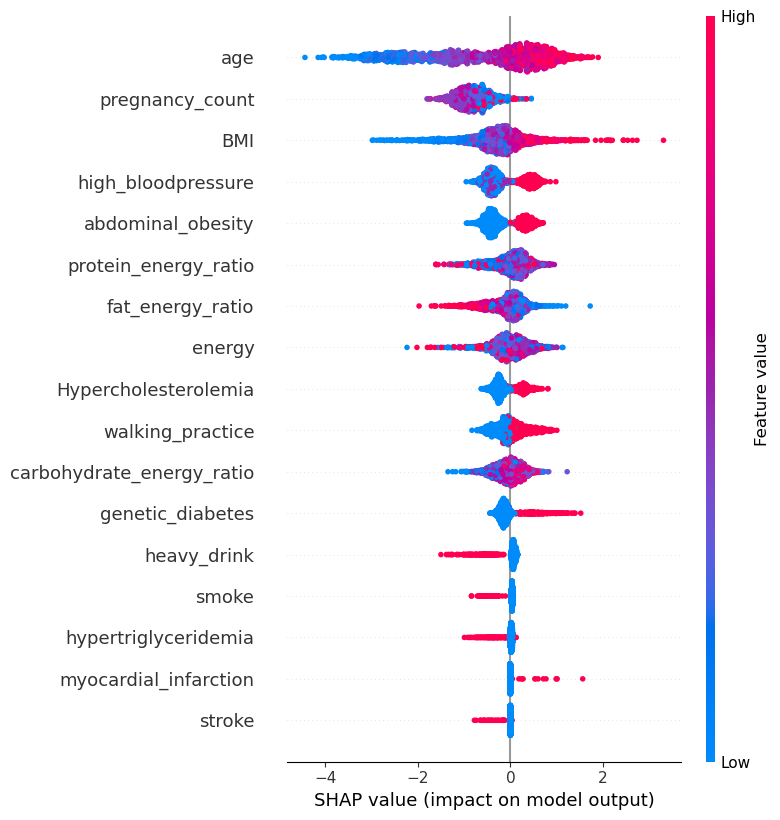

In [22]:
# 3. 모든 인스턴스에 대한 종합적인 해석
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns))

In [23]:
shap.initjs()
shap.plots.force(shap_values)

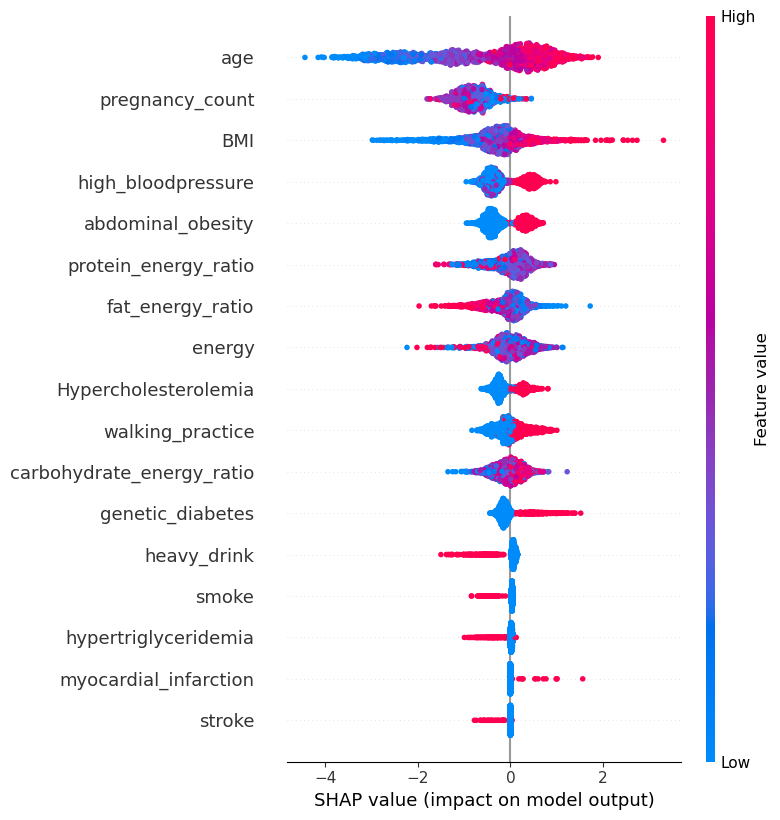

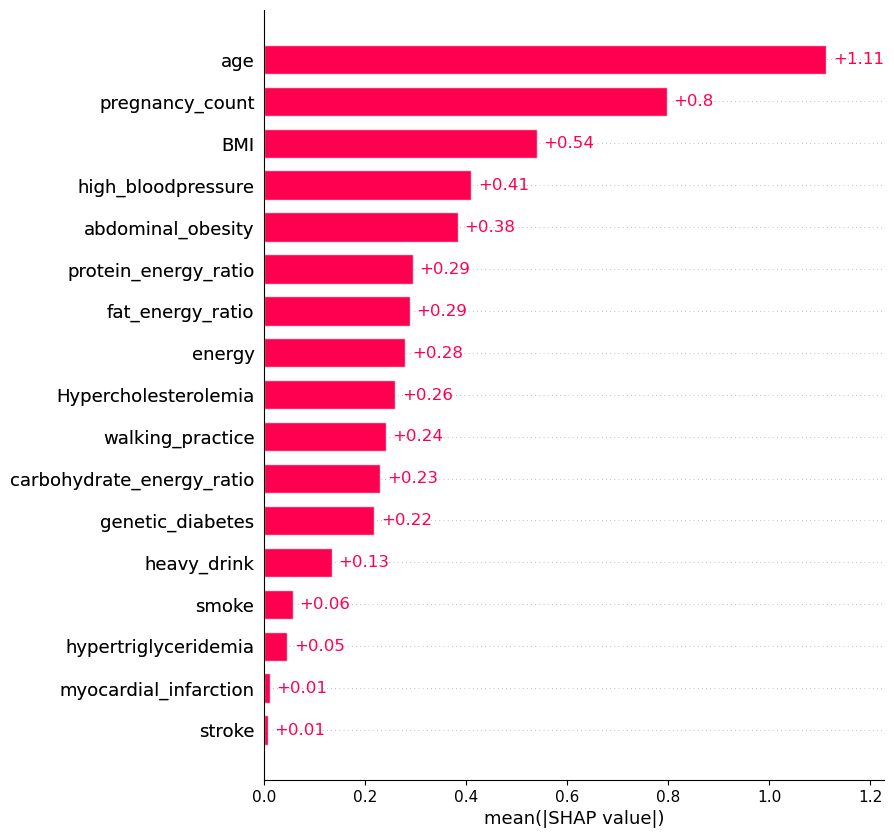

In [24]:
# 4. 모든 피처의 모델 영향력에 대한 해석
# 모든 피처를 확인하기 위해 max_display 옵션을 설정
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns))
shap.plots.bar(shap_values, max_display=len(X_test.columns))